In [285]:
#Reading from OPAL opacity table

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def txttodf(filename):
    with open(filename) as f:
        lines = f.readlines()
    
    dict = {}
    for k in range(126):
        arr = []
        log_T = []
        table_name = 'Table '+str(k+1)
        for j in range(70):
            arr1 = []
            for i in lines[6+77*k+j].split()[1:]: arr1.append(float(i))
            log_T.append(float(lines[6+77*k+j].split()[0]))
            arr.append(np.array(arr1))
            dict[table_name] = pd.DataFrame(arr)
    
    log_R = []
    for i in lines[4].split()[1:]: log_R.append(float(i))
    
    return dict, np.asarray(log_R), np.asarray(log_T)


filename = 'C:/Users/cyy24/Dropbox/Document/AS.171.611 Stellar Evolution/GN93hz.txt' 
diction, log_R, log_T = txttodf(filename) 
Table = diction['Table 73']
opacity = Table.to_numpy()
opacity = np.nan_to_num(opacity)

In [110]:
#Solar composition

Ms = 1.989e33 #g
Rs = 6.96e10 #cm
Ls = 3.826e33 #erg s**-1
Ts = 5778  #K
composition = {'X': 0.7, 'Y': 0.28, 'Z': 0.02}
mu = 4 / (3 + 5*composition['X'])
grad_ad = 0.4

In [111]:
#constansts

R_gas = 8.314462618e7  # Ideal gas constant in erg/(mol K)
k = 1.38e-16  # Gas constant in erg/K
m_u = 1.66e-24  # Atomic mass unit g
sigma = 5.670374419e-5  # erg/(cm^2 K^4 s)
a = 7.5657e-15 #erg cm^-3 K^-4
c = 2.998e10 #cm s^-1
G = 6.67430e-8 #cm^3 g^-1 s^-2

In [112]:
import scipy as sp

#interpolate the opacity table
interp = sp.interpolate.interp2d(log_R,log_T,opacity)

In [18]:
import math

def energy_generation_rate(density, temperature, composition):

    X = composition['X']
    Y = composition['Y']
    Z = composition['Z']
    
    #weak screening
    t7 = temperature/10**7
    f11 = 5.92e-3*(density/(T7**3))**(1/2)

    # Reaction rates
    # Proton-proton chain reactions
    R_pp = 2.4e4 * density * X**2 * (temperature/1e9)**(-2/3) * math.exp(-3.38*(temperature/1e9)**(-1/3))

    # CNO cycle reactions
    R_CNO = 4.4e25 * density * X * Z * (temperature/1e9)**(-2/3) * math.exp(-15.228*(temperature/1e9)**(-1/3))

    epsilon_pp = f11 * (R_pp1 + R_pp2 + R_pp3)
    epsilon_cno = R_CNO1 + R_CNO2 + R_CNO3

    epsilon = epsilon_pp + epsilon_cno

    return epsilon

In [116]:
def calculate_density(P, T):
    
    # Radiation pressure
    Prad = a * T**4 / 3

    # Density
    density = (P - Prad) * mu / (k * T * m_u)

    return density

In [280]:
def load1(guess):
    # Compute initial values slightly away from the center

    L_guess, Pc_guess, R_guess, Tc_guess = guess
    l = sigma*Tc_guess**4
    P = Pc_guess
    r = 0.01
    T = Tc_guess

    return np.array([l, P, r, T])

In [276]:
def load2(guess):
    # Compute initial values at the surface
    
    L_guess, Pc_guess, R_guess, Tc_guess = guess
    l = L_guess 
    P = Pc_guess
    r = R_guess
    T = (L_guess/sigma)**(1/4)

    return np.array([l, P, r, T])

In [277]:
def derivs(y ,m, composition):
    #Compute the derivatives dl/dm, dP/dm, dr/dm, and dT/dm.
 
    #unpacking
    l, P, r, T = y
    
    #calculate the density
    density = calculate_density(P,T)

    #find the actual temperature gradient
    #logT = np.log10(T)
    #logrho = np.log10(density)
    #logR = logrho - (3*logT - 18)
    #kappa = interp(logR,logT)
    kappa = -0.5
    grad_rad = (3 * P * kappa * l) / (16 * np.pi * a * c * T**4 * G * m)
    grad_actual = min(grad_rad, grad_ad)

    # Compute the derivatives using the provided equations
    dldm = energy_generation_rate(density, T, composition)
    dPdm = - (G * m) / (4 * np.pi * r**4)
    drdm = 1 / (4 * np.pi * r**2 *density)
    dTdm = - (G * m * T) / (4 * np.pi * r**4 * P) *grad_actual

    return np.array([dldm, dPdm, drdm, dTdm])

In [272]:
from scipy.integrate import odeint
def shootf(v):
    # Shooting method to calculate the discrepany between inward and outward integration
    
    # Define initial and final mass points
    m_center = 0.01
    m_surface = Ms
    m_middle = Ms / 2  # Middle mass point

    # Define number of variables and initial guesses
    nvar = 4
    y_center = load1(v)
    y_surface = load2(v)

    # Define integration parameters
    h_center = (m_middle - m_center) / 100.0
    h_surface = (m_middle - m_surface) / 100.0
    hmin = 0.0
    atol = 1e-10
    rtol = 1e-10

    # Integrate from center to middle
    y_solution_center = odeint(derivs, y_center, [m_center, m_middle], args=(composition,))
    f_center = y_solution_center[-1] - load2(v)

    # Integrate from surface to middle
    y_solution_surface = odeint(derivs, y_surface, [m_surface, m_middle], args=(composition,))
    f_surface = y_solution_surface[-1] - load1(v)

    # Calculate difference between values at middle point
    f = np.concatenate((f_center[:nvar] - f_surface[:nvar], f_center[nvar:] + f_surface[nvar:]))

    return f

In [261]:

def approx_jacobian(func, x0, epsilon=1e-8):
    # approximate the jacobian matrix
    
    n = len(x0)
    jacobian = np.zeros((n, n))
    f0 = func(x0)

    for i in range(n):
        perturbation = np.zeros(n)
        perturbation[i] = epsilon
        x_plus = x0 + perturbation
        f_plus = func(x_plus)
        jacobian[:, i] = (f_plus - f0) / epsilon

    return jacobian

In [262]:
def solve_boundary_problem(v_guess, shootf, load1, load2, max_iter=100, tol=1e-6):
    #Solve a boundary value problem by Newton's method
    i = 0
    v = np.array(v_guess)
    for i in range(max_iter):
        print(i)
        y = shootf(v)
        if np.linalg.norm(y) < tol:
            return v
        J = approx_jacobian(shootf, v, epsilon=1e-8)
        delta_v = np.linalg.solve(J, -y)
        v += delta_v
        i += 1

    raise RuntimeError("Maximum number of iterations reached.")

In [278]:
# Estimate initial guesses for the Sun

L_guess_i = Ls
Pc_guess_i = 2.477e16 #dyn/cm^2
R_guess_i= Rs
Tc_guess_i = 15e6
v_guess = [L_guess_i, Pc_guess_i, R_guess_i, Tc_guess_i]

In [ ]:
#plotting the solutions

import numpy as np
import matplotlib.pyplot as plt

# Define the range of mass points
m_points = np.linspace(0, Ms, num=100)


# Initialize lists to store the solutions
l_solutions = []
P_solutions = []
r_solutions = []
T_solutions = []

# Iterate over each mass point and solve the boundary value problem
for m in m_points:
    # Solve the boundary value problem using the shootf function
    solutions = solve_boundary_problem(v_guess, shootf, load1, load2)

    # Extract the solutions for l, P, r, T
    l_solution = solutions[0]
    P_solution = solutions[1]
    r_solution = solutions[2]
    T_solution = solutions[3]

    # Append the solutions to the respective lists
    l_solutions.append(l_solution)
    P_solutions.append(P_solution)
    r_solutions.append(r_solution)
    T_solutions.append(T_solution)


# Plot the solutions as functions of m
plt.figure(figsize=(10, 6))
plt.plot(m_points, l_solutions, label='l(m)')
plt.plot(m_points, P_solutions, label='P(m)')
plt.plot(m_points, r_solutions, label='r(m)')
plt.plot(m_points, T_solutions, label='T(m)')
plt.xlabel('Mass (m)')
plt.ylabel('Values')
plt.title('Stellar Structure')
plt.legend()
plt.show()

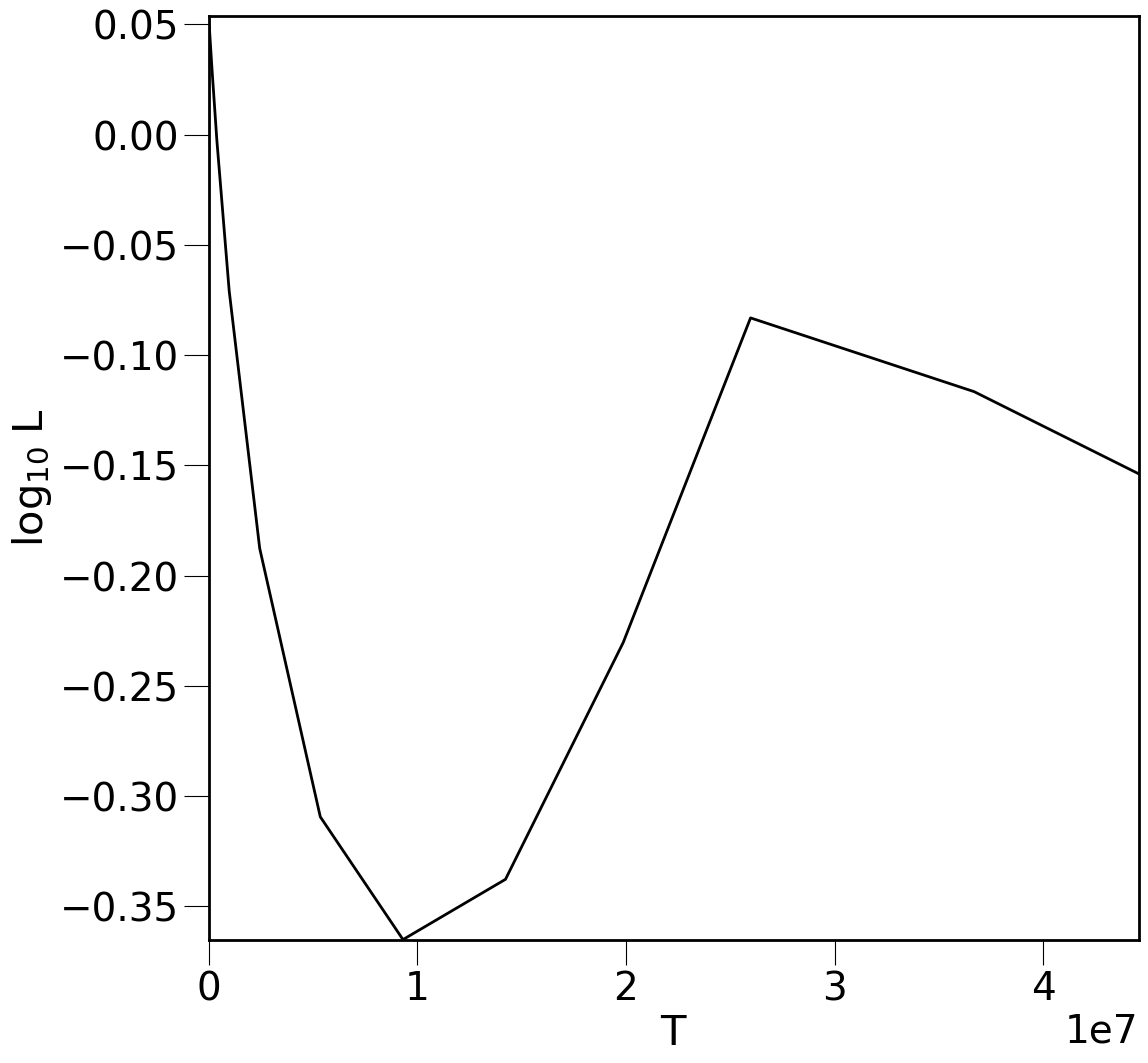

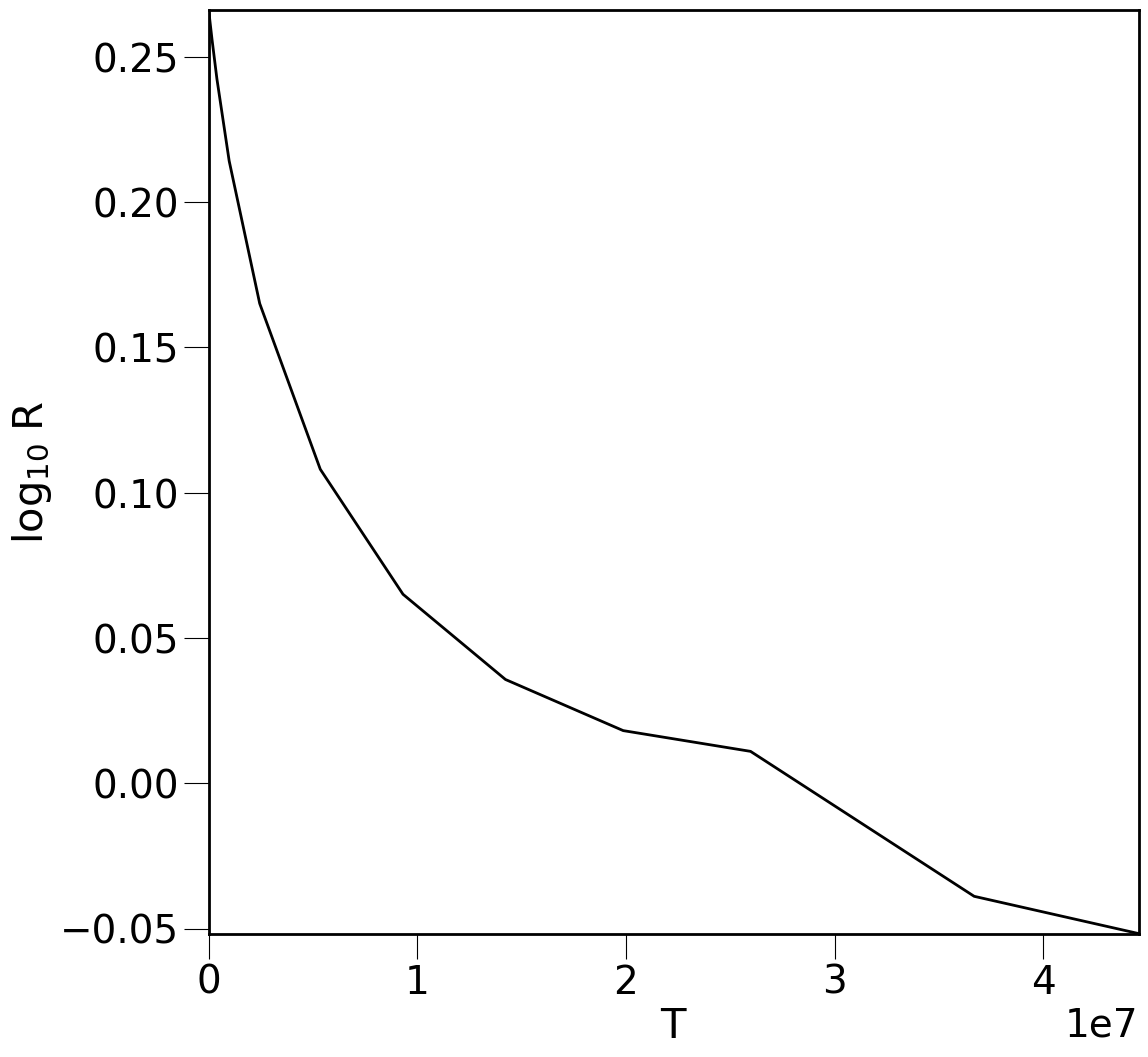

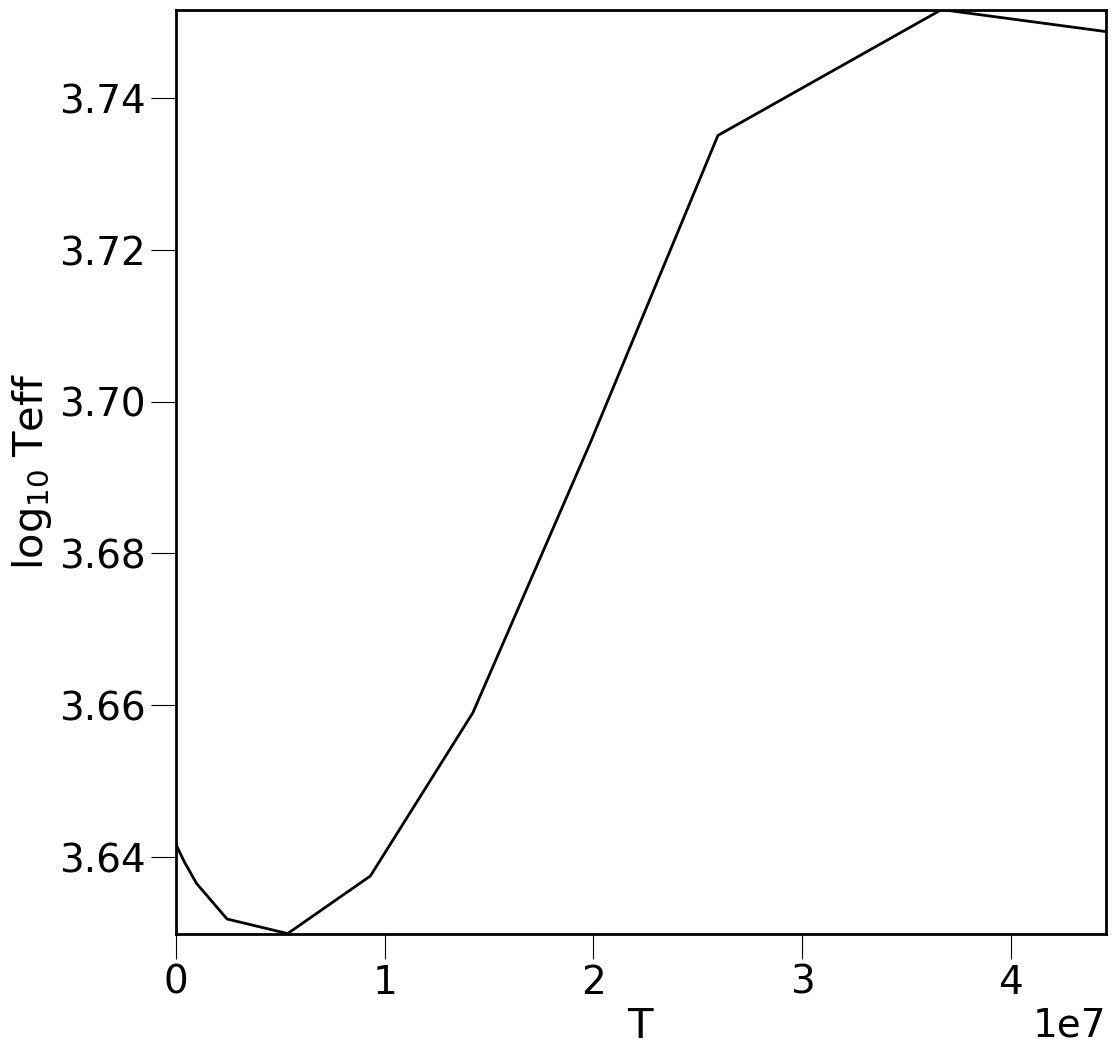

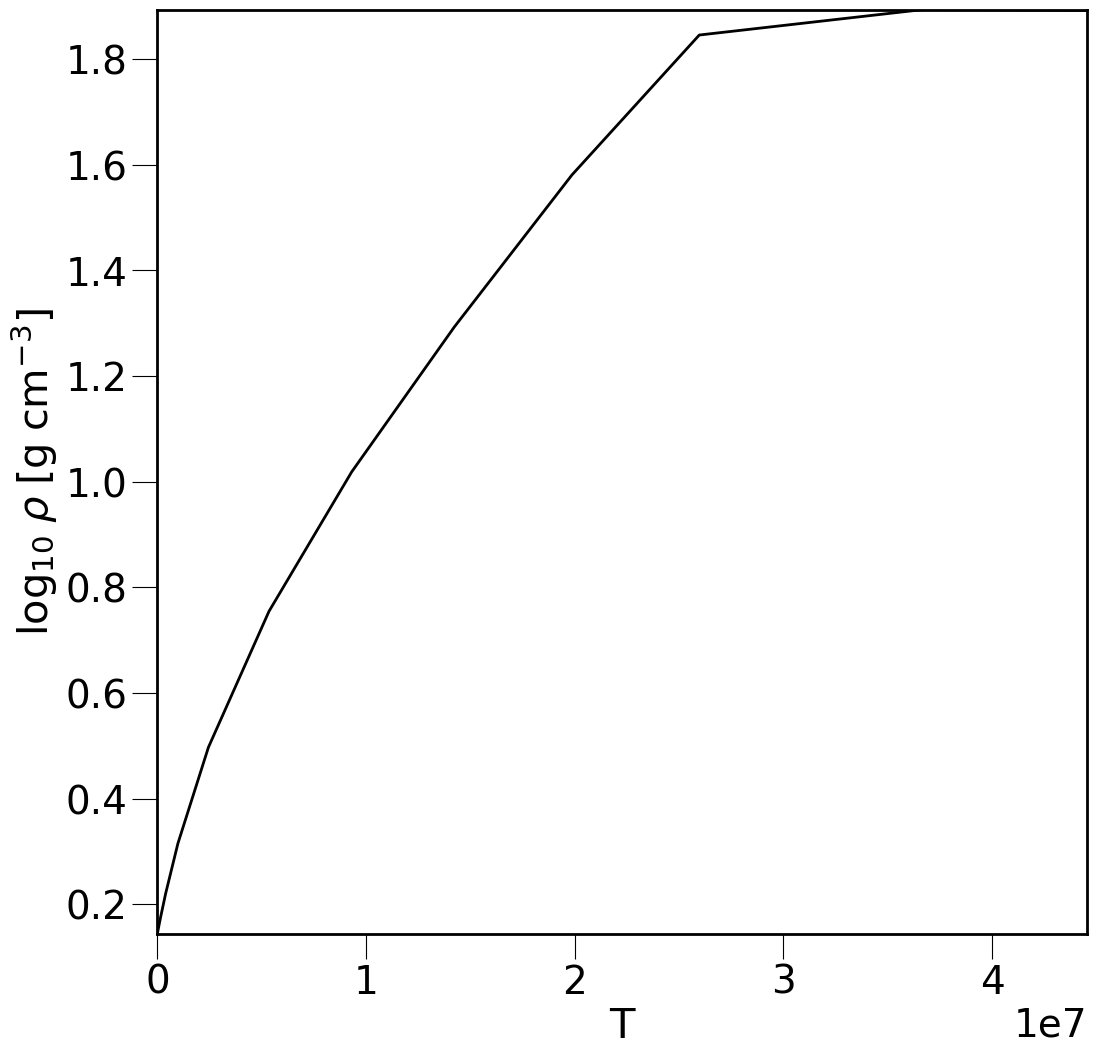

FileNotFoundError: No file  found

In [31]:
#Plotting history data and profile data from MESA

import mesaPlot as mp
m = mp.MESA()
# Load the history data
m.log_fold = 'C:/Users/cyy24/Dropbox/Document/AS.171.611 Stellar Evolution/MESA'
history_data = m.loadHistory()

# Plotting parameters
p=mp.plot()

p.plotHistory(m,xaxis='star_age',y1='log_L')
p.plotHistory(m,xaxis='star_age',y1='log_R')
p.plotHistory(m,xaxis='star_age',y1='log_Teff')
p.plotHistory(m,xaxis='star_age',y1='log_cntr_Rho')

# Load the profile data
m.loadProfile()
p=mp.plot()

fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(111)

#Simply plot
p.plotTRho(m,fig=fig,ax=ax,show=False,showAll=True,show_mix=True)
plt.show()
